<a href="https://colab.research.google.com/github/vinicius-silva-ep/Topicos_Especiais_Em_Engenharia_Economica/blob/main/Fatos_Estilizados_Vinicius_Silva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisando Fatos Estilizados

## Baixando e importando bibliotecas

In [1]:
!pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.4 MB/s 


In [2]:
import pandas as pd
from yahooquery import Ticker
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm
from scipy.stats import skew, kurtosis, shapiro, jarque_bera
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Importando dados

### Dados com escala intradia

Extraindo dados em escala intradia. Os intervalos suportados são:


* 30 min -> últimos 60 dias úteis
* 15 min -> últimos 60 dias úteis
* 05 min -> últimos 60 dias úteis
* 02 min -> últimos 31 dias úteis
* 01 min -> últimos 07 dias úteis



In [5]:
# Extraindo dados dos últimos 60 dias em um intervalo de 30 minutos
# Lembrar de colocar o "SA" depois de colocar o nome da ação
abev = Ticker("ABEV3.SA")
abev.history(period="60d",  interval = "30m")

close   high        low       open   volume
symbol   date                                                                
ABEV3.SA 2022-07-14 10:00:00  14.660000  14.71  14.370000  14.380000  3138000
         2022-07-14 10:30:00  14.650000  14.73  14.560000  14.650000  5496600
         2022-07-14 11:00:00  14.560000  14.68  14.550000  14.640000  2846600
         2022-07-14 11:30:00  14.600000  14.62  14.520000  14.550000  2114700
         2022-07-14 12:00:00  14.650000  14.70  14.510000  14.590000  5827000
...                                 ...    ...        ...        ...      ...
         2022-10-06 15:00:00  16.090000  16.17  16.059999  16.170000  5639600
         2022-10-06 15:30:00  16.040001  16.17  16.030001  16.080000  3021400
         2022-10-06 16:00:00  16.080000  16.09  16.010000  16.049999  2268500
         2022-10-06 16:30:00  16.070000  16.08  16.020000  16.080000  1438200
         2022-10-06 17:00:00  16.150000  16.15  16.150000  16.150000        0

[841 rows x 5 columns]

In [6]:
abev = abev.history(period='7d',  interval = '1m')
abev

open       high      close        low  \
symbol   date                                                              
ABEV3.SA 2022-09-28 10:03:00  15.420000  15.450000  15.450000  15.410000   
         2022-09-28 10:04:00  15.430000  15.600000  15.540000  15.400000   
         2022-09-28 10:05:00  15.540000  15.560000  15.460000  15.460000   
         2022-09-28 10:06:00  15.480000  15.490000  15.460000  15.460000   
         2022-09-28 10:07:00  15.460000  15.460000  15.450000  15.450000   
...                                 ...        ...        ...        ...   
         2022-10-06 16:51:00  16.059999  16.070000  16.070000  16.059999   
         2022-10-06 16:52:00  16.059999  16.070000  16.049999  16.049999   
         2022-10-06 16:53:00  16.049999  16.059999  16.040001  16.040001   
         2022-10-06 16:54:00  16.059999  16.070000  16.070000  16.040001   
         2022-10-06 17:00:00  16.150000  16.150000  16.150000  16.150000   

                                volume  
symbol   date                           
ABEV3.SA 2022-09-28 10:03:00       0.0  
         2022-09-28 10:04:00  393200.0  
         2022-09-28 10:05:00   52300.0  
         2022-09-28 10:06:00   39200.0  
         2022-09-28 10:07:00    8300.0  
...                                ...  
         2022-10-06 16:51:00   15600.0  
         2022-10-06 16:52:00   23500.0  
         2022-10-06 16:53:00   26200.0  
         2022-10-06 16:54:00   25400.0  
         2022-10-06 17:00:00       0.0  

[2866 rows x 5 columns]

## Fato Estilizado 1: Distribuições não Gaussianas

Identificando o período dos dados totais disponíveis

In [7]:
ticker = 'PETR4.SA' # É importante o ".SA" no final do código da ação
nome = 'PETROBRAS'
periodo = Ticker(ticker)
periodo.history(period='max').reset_index()['date']

0       2000-01-03
1       2000-01-04
2       2000-01-05
3       2000-01-06
4       2000-01-07
           ...    
5716    2022-09-30
5717    2022-10-03
5718    2022-10-04
5719    2022-10-05
5720    2022-10-06
Name: date, Length: 5721, dtype: object

Selecionando o período e coluna de fechamento dos preços. A coluna de fechamento é renomeada para o nome da empresa escolhida

In [8]:
data_inicial = '2000-01-03'
data_final = '2022-10-07'
acao = periodo.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
acao

,PETROBRAS
date,
2000-01-03,5.875000
2000-01-04,5.550000
2000-01-05,5.494000
2000-01-06,5.475000
2000-01-07,5.500000
...,...
2022-09-30,29.799999
2022-10-03,32.180000
2022-10-04,31.370001


Calculando a função de densidade de probabilidade normal utilizando a média e o desvio padrão dos retornos observados

In [9]:
retornos = acao.pct_change().dropna()
r_range = np.linspace(retornos.min(), retornos.max(), num=1000)
mu = retornos.mean()
sigma = retornos.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

Plotando o histograma e o Q-Q plot

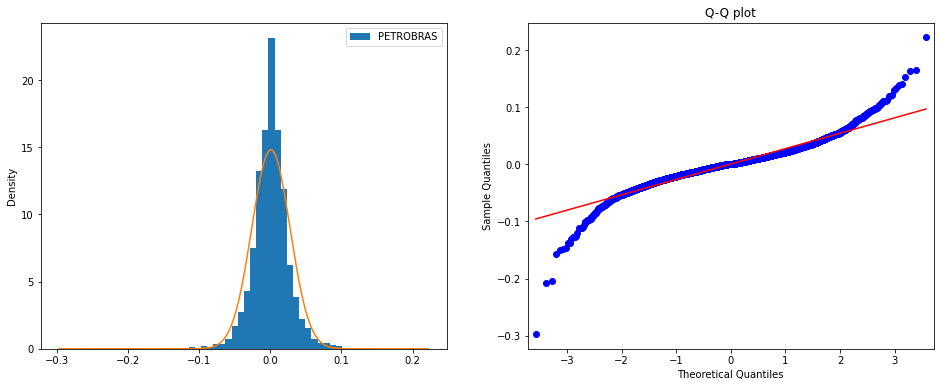

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Histograma comparando com uma distribuição normal de mesma média e desvio padrão:
retornos.plot.hist(density=True, bins=60, ax=ax[0], ylabel='Density');
# parâmetros para curva normal
mediaR = retornos.mean()
desvpadR = retornos.std()
minR = retornos.min()
maxR = retornos.max()
x = np.linspace(minR,maxR,1000)
ax[0].plot(x, scs.norm.pdf(x,loc=mediaR,scale=desvpadR))
ax[0].set(ylabel='Density')

# Q-Q plot
qq = sm.qqplot(retornos[nome].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 12)
plt.show()

Teste quantitativo de normalidade de Shapiro-Wilk

In [11]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
shapirowilk = shapiro(retornos)
if shapirowilk[1] <= 0.05:
  print("Hipotese Nula Rejeitada")
else:
  print("Não rejeitar hipotese nula") #minha amostra possui uma distribuição normal

print('O valor-p calculado foi de', shapirowilk[1])

Hipotese Nula Rejeitada
O valor-p calculado foi de 1.401298464324817e-45


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Teste quantitativo de normalidade de Jarque-Bera

In [12]:
# Este teste tem como hipótese nula que a amostra possui uma distribuição normal. 
# Caso o valor p < 0.05 a hipótese nula é rejeitada significando que os dados da amostra não são normalmente distribuídos
jarque_bera(retornos)

Jarque_beraResult(statistic=15727.89602124126, pvalue=0.0)

In [13]:
# Jarque-Bera implementado "na unha"
JB = (len(retornos)/6)*( skew(retornos)**2 + (1/4)*(kurtosis(retornos)**2 ))
JB

array([15727.89602124])

Comparando o teste com dados normalmente distribuídos

In [14]:
norm = np.random.randn(len(retornos))
jarque_bera(norm)

Jarque_beraResult(statistic=2.6924601994609954, pvalue=0.26021941507197677)

## Fato Estilizado 2: Aglomerados de volatilidade

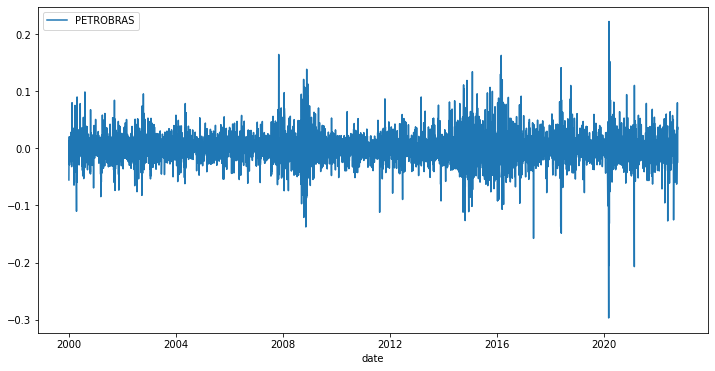

In [15]:
retornos.plot(figsize=(12,6));

## Fato Estilizado 3: Ausência de autocorrelação

Autocorrelação dos retornos diários

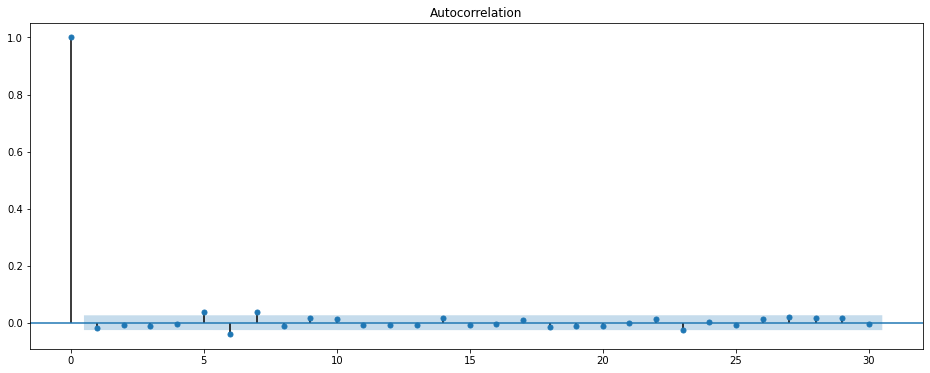

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos,lags=30, ax=ax)
plt.show()

Retornos em 1 min

In [17]:
acao1m = periodo.history(period='7d',  interval = '1m')
acao1m = acao1m.rename({"close": nome}, axis=1).xs(ticker)
acao1m = acao1m[[nome]]
acao1m

,PETROBRAS
date,
2022-09-28 10:03:00,29.740000
2022-09-28 10:04:00,29.680000
2022-09-28 10:05:00,29.680000
2022-09-28 10:06:00,29.660000
2022-09-28 10:07:00,29.650000
...,...
2022-10-06 16:51:00,33.709999
2022-10-06 16:52:00,33.740002
2022-10-06 16:53:00,33.740002


Autocorrelação dos retornos em 1 min

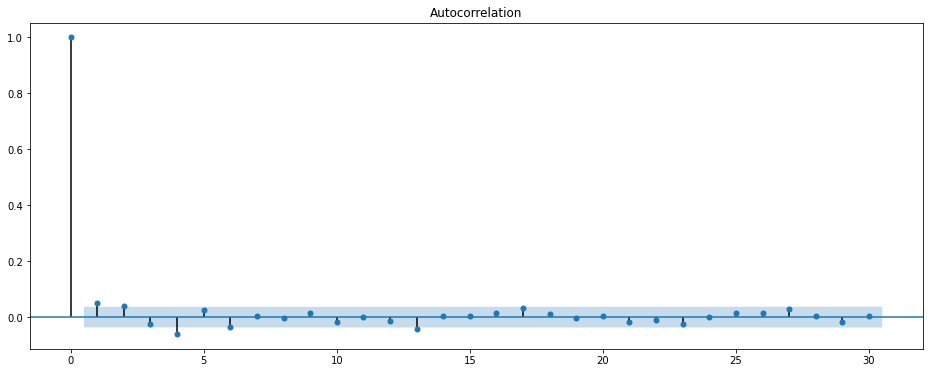

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))
retornos1m = acao1m.pct_change().dropna()
plot_acf(retornos1m,lags=30, ax=ax)
plt.show()

## Fato Estilizado 4: Decaimento lento da autocorrelação dos quadrados dos retornos

Decaimento lento da autocorrelação do quadrado dos retornos

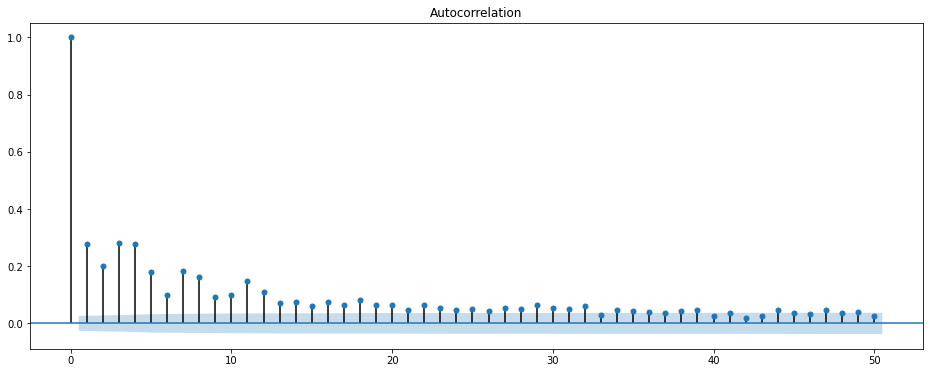

In [19]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(retornos**2,lags=50, alpha=0.05, ax=ax)
plt.show()

É válido também para o módulo dos retornos

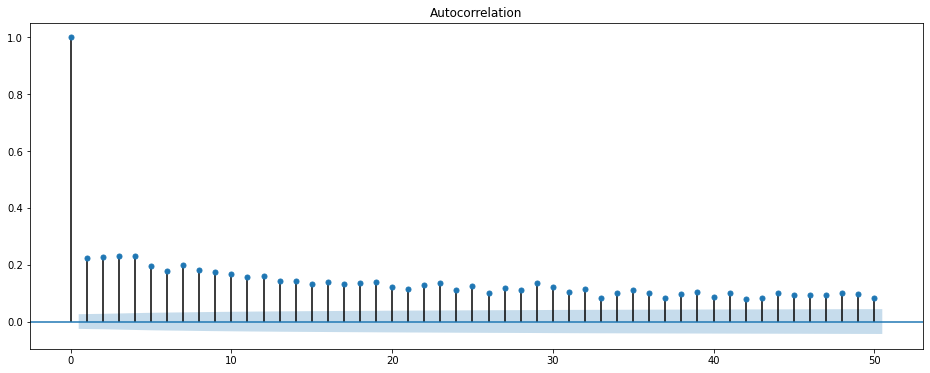

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(abs(retornos),lags=50, alpha=0.05, ax=ax)
plt.show()

## Fato Estilizado 5: Efeito de alavancagem

In [21]:
desv_pad_21d = retornos[nome].rolling(window=21).std()
desv_pad_21d

date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
                ...   
2022-09-30    0.020622
2022-10-03    0.027354
2022-10-04    0.027730
2022-10-05    0.029089
2022-10-06    0.028781
Name: PETROBRAS, Length: 5720, dtype: float64

In [22]:
desv_pad_252d = retornos[nome].rolling(window=252).std()

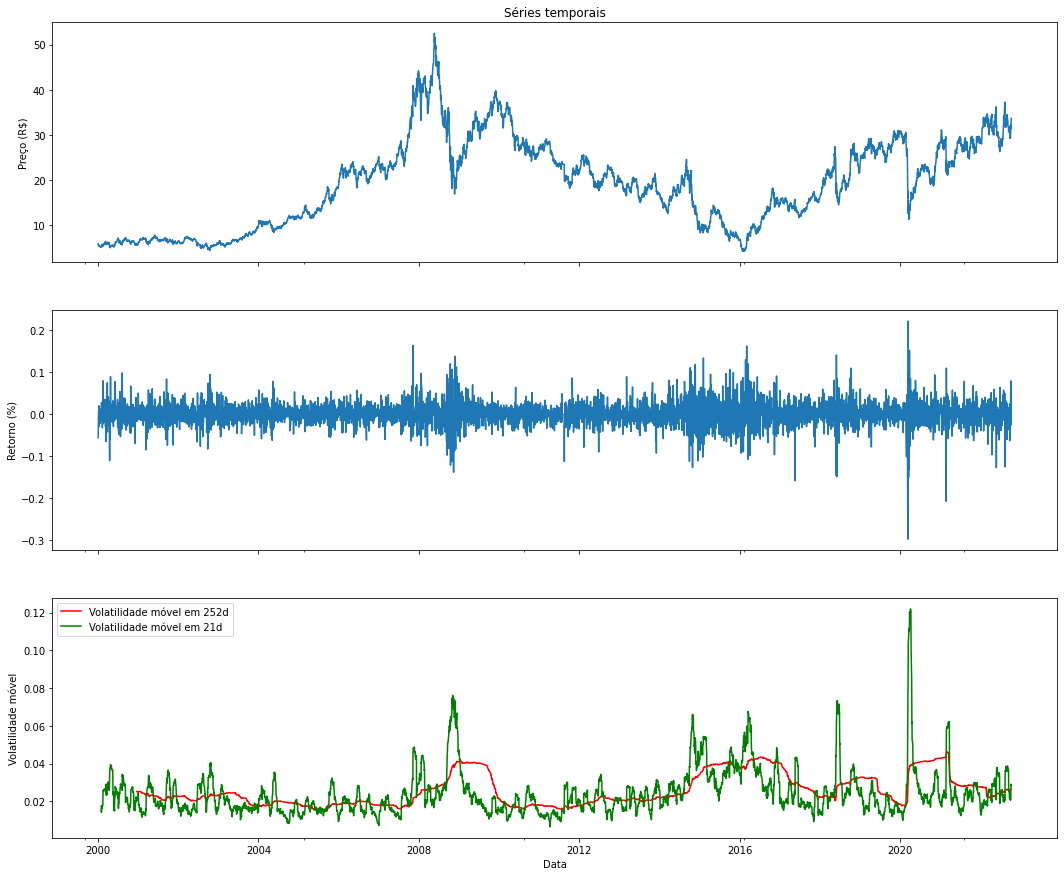

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
acao[nome].plot(ax=ax[0])
ax[0].set(title='Séries temporais', ylabel='Preço (R$)')
retornos[nome].plot(ax=ax[1])
ax[1].set(ylabel='Retorno (%)')
desv_pad_252d.plot(ax=ax[2], color='r', label='Volatilidade móvel em 252d')
desv_pad_21d.plot(ax=ax[2], color='g', label='Volatilidade móvel em 21d')
ax[2].set(ylabel='Volatilidade móvel', xlabel='Data')
ax[2].legend()
plt.show()

## Fato Estilizado 6: Gaussianidade agregativa

In [25]:
# Testar depois

## Corrlação entre ações/índices

In [26]:
nome_ibov = 'IBOVESPA'
periodo_ibov = Ticker('^BVSP')
#ibov = periodo_ibov.history(start= data_inicial, end= data_final, interval='1d').xs(ticker)
ibov = periodo_ibov.history(period='60d', interval='1d').xs('^BVSP')
ibov = ibov.rename({"close": nome_ibov}, axis=1)
ibov = ibov[[nome_ibov]]
ibov

,IBOVESPA
date,
2022-07-14,96121.000000
2022-07-15,96551.000000
2022-07-18,96916.000000
2022-07-19,98245.000000
2022-07-20,98287.000000
2022-07-21,99033.000000
2022-07-22,98925.000000
2022-07-25,100270.000000
2022-07-26,99772.000000


In [27]:
retornos_ibov = ibov.pct_change().dropna()
retornos_ibov

,IBOVESPA
date,
2022-07-15,0.004474
2022-07-18,0.003780
2022-07-19,0.013713
2022-07-20,0.000428
2022-07-21,0.007590
2022-07-22,-0.001091
2022-07-25,0.013596
2022-07-26,-0.004967
2022-07-27,0.016698


In [28]:
retornos_ibov.shape

(59, 1)

In [29]:
ticker = 'PETR4.SA' # É importante o ".SA" no final do código da ação
nome = 'PETROBRAS'
acao = periodo.history(period='60d', interval='1d').xs(ticker)
acao = acao.rename({"close": nome}, axis=1)
acao = acao[[nome]]
acao

,PETROBRAS
date,
2022-07-14,27.490000
2022-07-15,27.959999
2022-07-18,28.600000
2022-07-19,29.180000
2022-07-20,29.170000
2022-07-21,29.020000
2022-07-22,29.330000
2022-07-25,30.700001
2022-07-26,31.010000


In [30]:
retornos = acao.pct_change().dropna()
retornos

,PETROBRAS
date,
2022-07-15,0.017097
2022-07-18,0.022890
2022-07-19,0.020280
2022-07-20,-0.000343
2022-07-21,-0.005142
2022-07-22,0.010682
2022-07-25,0.046710
2022-07-26,0.010098
2022-07-27,0.010964


In [36]:
df = pd.concat([retornos,retornos_ibov], axis=1)
df

,PETROBRAS,IBOVESPA
date,,
2022-07-15,0.017097,0.004474
2022-07-18,0.022890,0.003780
2022-07-19,0.020280,0.013713
2022-07-20,-0.000343,0.000428
2022-07-21,-0.005142,0.007590
2022-07-22,0.010682,-0.001091
2022-07-25,0.046710,0.013596
2022-07-26,0.010098,-0.004967
2022-07-27,0.010964,0.016698


0.4148789942071162

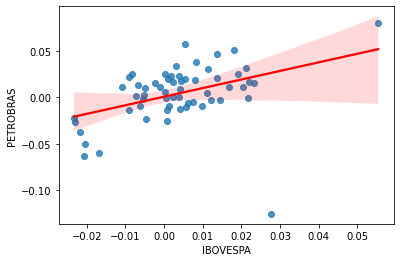

In [37]:
corr_coeff = df[nome_ibov].corr(df[nome])
ax = sns.regplot(x=nome_ibov, y=nome, data=df, line_kws={'color': 'red'})
#ax.set(title=f'S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})',
corr_coeff